## Cell typing by data integration and by classification

Here, we walk you through three ways to predict the cell types in your *query* scRNAseq data set by leveraging another, well-annotated *reference* dataset. The first way is to directly combine the datasets and cluster them together. The second way is called 'Batch Balanced KNN', which works by finding kNN across batches. The third way is to classify the query data with classifier that was trained with the reference data. 

### Data

We will use mouse cells from gastrula-stage embryos from two studies.

The reference data comes from [Pijuan-Sala et al 2019](https://pubmed.ncbi.nlm.nih.gov/30787436/) which describes a single cell census of gastrulation in mouse (E6.5 to E8.5). You can download [the .h5ad file here](https://jhu.instructure.com/files/13371890/download?download_frd=1).

<figure>
    <img src="img/sc_gastrulation.png" alt="Fig 1 from Pijuan-Sala et al 2019" width="600">
    <figcaption>A single-cell resolution atlas of mouse gastrulation and early organogenesis. Fig 1 from <a href="https://pubmed.ncbi.nlm.nih.gov/30787436/">Pijuan-Sala et al 2019</a></figcaption>
</figure>


The query data comes from another gastrula census [Grosswendt et al 2020](https://pubmed.ncbi.nlm.nih.gov/32728215/). You can download [the .h5ad file here](https://jhu.instructure.com/files/13371891/download?download_frd=1).

For the sake of computational efficiency, we have taken only a small subset of the cells from each of these studies. The cell type label is stored in `.obs['celltype']`

### Environment setup

**Local (conda):** Create the environment from the provided [`cell_typing_integration_environment.yml`](cell_typing_integration_environment.yml):
```
conda env create -f cell_typing_integration_environment.yml
conda activate cscb
```

**Pip only:** Use [`cell_typing_integration_requirements.txt`](cell_typing_integration_requirements.txt):
```
pip install -r cell_typing_integration_requirements.txt
```

**Google Colab:** Run the cell below — it will detect Colab and install the required packages automatically. You will also need to upload the data files to `data/` in your Colab working directory.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print("Colab detected — installing required packages...")
    !pip install -q scanpy==1.10.3 anndata==0.11.1 bbknn==1.6.0 pySingleCellNet==0.1.3 leidenalg==0.10.2 igraph==0.11.8
else:
    print("Local environment detected — skipping install.")

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import pySingleCellNet as cn
import scanpy.external as sce
print(sys.executable)

/opt/homebrew/Caskroom/miniforge/base/envs/autocluster/bin/python3.12


In [ ]:
import bbknn
print(f"bbknn version: {bbknn.__version__}")

In [ ]:
adPijuan = sc.read_h5ad("data/ad_Pijuan_demo.h5ad")
adPijuan

In [4]:
adPijuan.obs['celltype'].value_counts()

celltype
Meso.Cardio     300
PGC             297
Endo.Gut        296
Epiblast        296
Anterior.PS     294
Ecto.Neural     294
Meso.Nascent    294
Name: count, dtype: int64

Standard pre-processing pipeline

In [5]:
adTrain = adPijuan
adTrain.layers['counts'] = adTrain.X.copy()
sc.pp.normalize_total(adTrain)
sc.pp.log1p(adTrain)
# Or choose your preferred HVG 
sc.pp.highly_variable_genes(adTrain, n_top_genes=2000, flavor='seurat_v3', layer='counts')

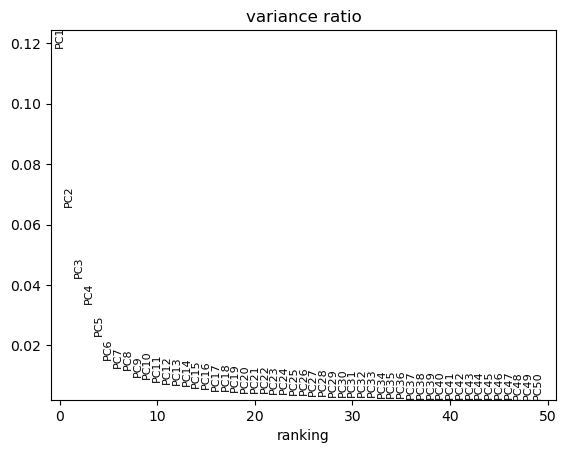

In [6]:
sc.tl.pca(adTrain, mask_var='highly_variable')
sc.pl.pca_variance_ratio(adTrain, n_pcs=50)

kNN and then UMAP for visualization

In [7]:
def_npcs = 20
def_nneigh = 10
sc.pp.neighbors(adTrain, n_neighbors = def_nneigh,  n_pcs = def_npcs)

Color cells by ground truth label and by developmental stage

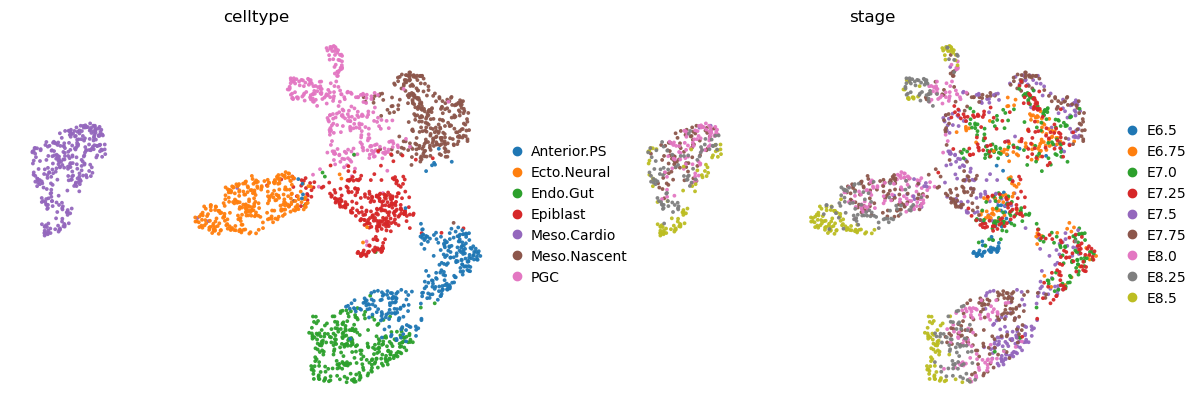

In [8]:
sc.tl.umap(adTrain)
sc.pl.umap(adTrain, color=['celltype', 'stage'], size=30, alpha=.95,frameon=False)

### Naive concatenation of anndata objects, then clustering
Now we will load the other scRNAseq data set from another study that also looked at mouse gastrulation.

In [ ]:
adGross = sc.read_h5ad("data/ad_Grosswendt_demo.h5ad")
adGross

In [ ]:
adPijuan = sc.read_h5ad("data/ad_Pijuan_demo.h5ad")
adPijuan.obs['study'] = 'Pijuan'
adGross.obs['study'] = 'Grosswendt'

In [11]:
import anndata as ad
del(adPijuan.raw)
adComb = ad.concat([adPijuan, adGross])

In [14]:
adComb.obs['study'].value_counts()

study
Pijuan        2071
Grosswendt     700
Name: count, dtype: int64

/opt/homebrew/Caskroom/miniforge/base/envs/autocluster/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


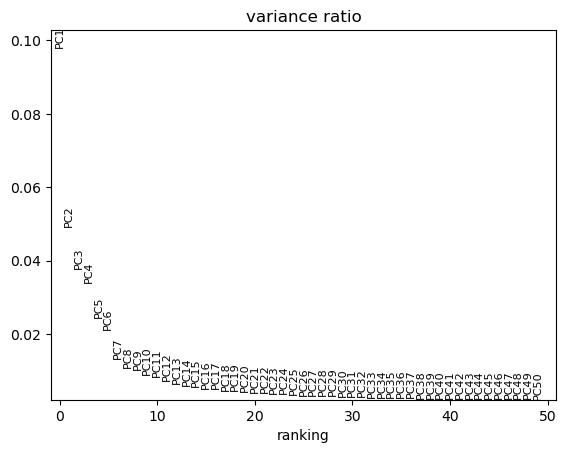

In [15]:
adComb.layers['counts'] = adComb.X.copy()
sc.pp.normalize_total(adComb)
sc.pp.log1p(adComb)
sc.pp.highly_variable_genes(adComb, n_top_genes=2000, flavor='seurat_v3', layer='counts')
sc.tl.pca(adComb, mask_var='highly_variable')
sc.pl.pca_variance_ratio(adComb, n_pcs=50)

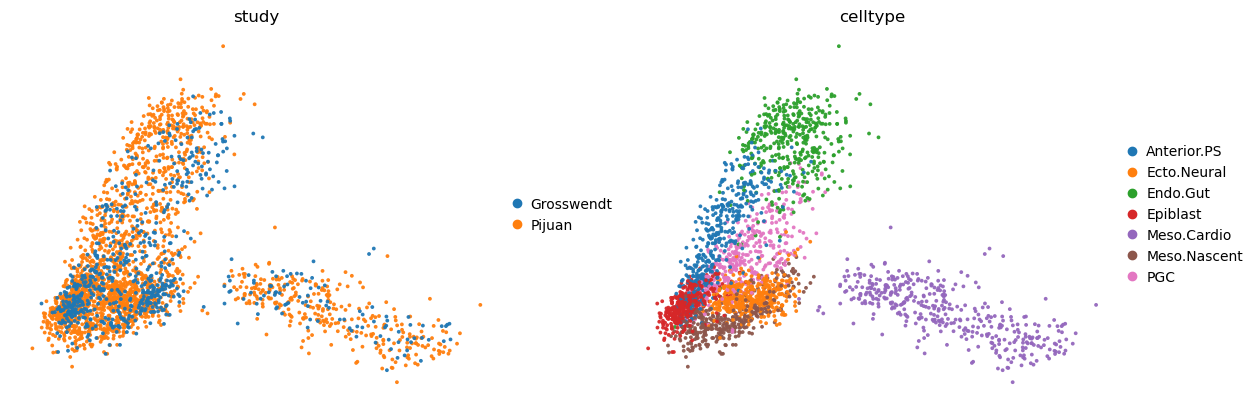

In [16]:
sc.pl.pca(adComb, color=['study', 'celltype'], size=30, alpha=.95,frameon=False)

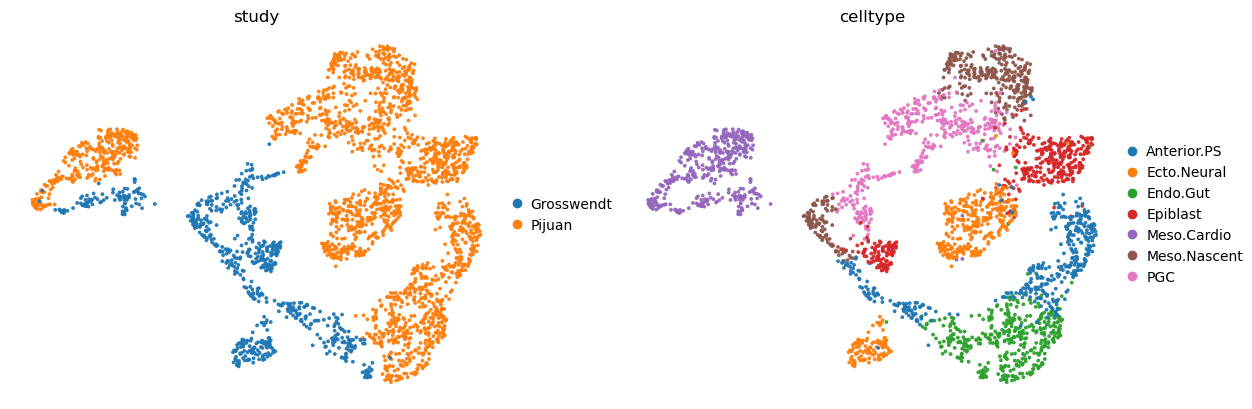

In [17]:
def_npcs = 20
def_nneigh = 10 # my preference -- lower values tend to facilitate detection of rarer populations
sc.pp.neighbors(adComb, n_neighbors = def_nneigh,  n_pcs = def_npcs)
sc.tl.umap(adComb)
sc.pl.umap(adComb, color=['study', 'celltype'], size=30, alpha=.95,frameon=False)

The embedding above strongly suggests that cells clustering will be dominated by study over cell type. Let's test this...

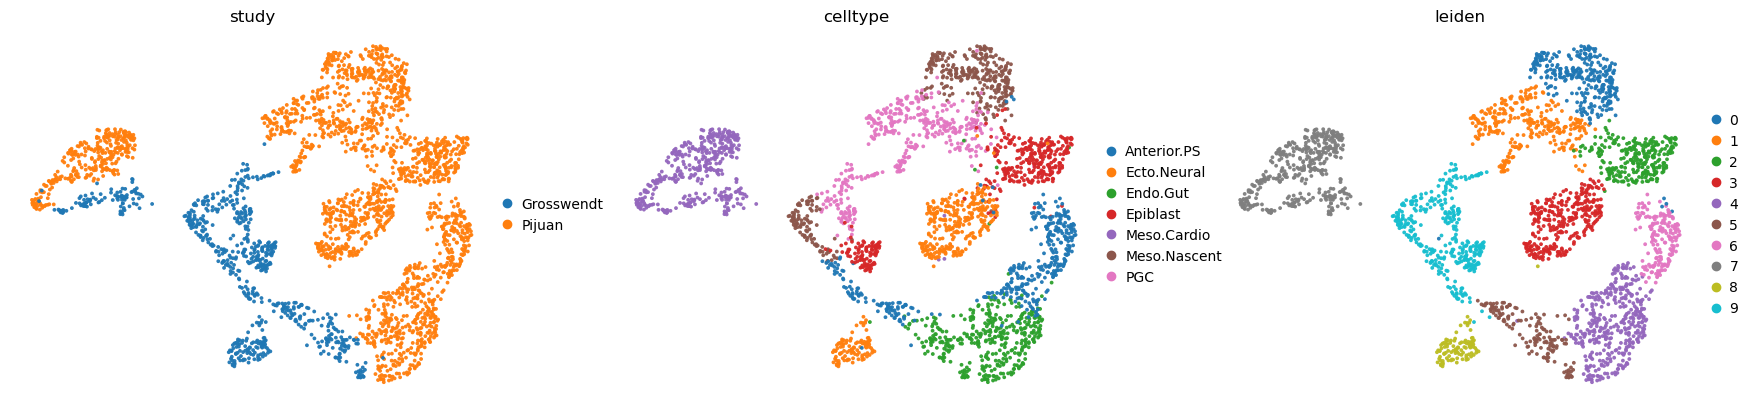

In [18]:
sc.tl.leiden(adComb, 0.25, flavor="igraph", n_iterations=2, directed=False)
sc.pl.umap(adComb, color=['study', 'celltype', 'leiden'], size=30, alpha=.95,frameon=False)

### Method 2: BBKNN

Let's test Batch Balanced K Nearest Neighbors (BBKNN) ([Polanski et al 2020](https://pubmed.ncbi.nlm.nih.gov/31400197/)), a graph-based integration method. Rather than aligning expression values across batches, BBKNN modifies the KNN graph construction step so that each cell's neighbors are balanced across batches. This corrected graph is then used for downstream steps like UMAP and clustering.

For details on how the `sc.external.pp.bbknn()` function works, see [scanpy's documentation](https://scanpy.readthedocs.io/en/stable/generated/scanpy.external.pp.bbknn.html). 

Also see the section on [graph-based integration in the online best practices book](https://www.sc-best-practices.org/cellular_structure/integration.html#graph-based-integration).

If bbknn is not already installed in your environment, install it with:

```
pip install bbknn
```

See https://github.com/Teichlab/bbknn for more details. Note: bbknn >= 1.6.0 is required for compatibility with scikit-learn >= 1.3.

In [16]:
adComb2 = ad.concat([adPijuan, adGross])
batch_key = "study"

sc.pp.filter_genes(adComb2, min_cells=3)
adComb2.layers['counts'] = adComb2.X.copy()

In [17]:
sc.pp.normalize_total(adComb2)
sc.pp.log1p(adComb2)
sc.pp.highly_variable_genes(adComb2, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key)

In [ ]:
adata_hvg = adComb2[:,adComb2.var["highly_variable"]].copy()
sc.pp.pca(adata_hvg)
sce.pp.bbknn(adata_hvg, batch_key=batch_key)

In [18]:
adata_hvg

AnnData object with n_obs × n_vars = 2771 × 2000
    obs: 'stage', 'celltype', 'study'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

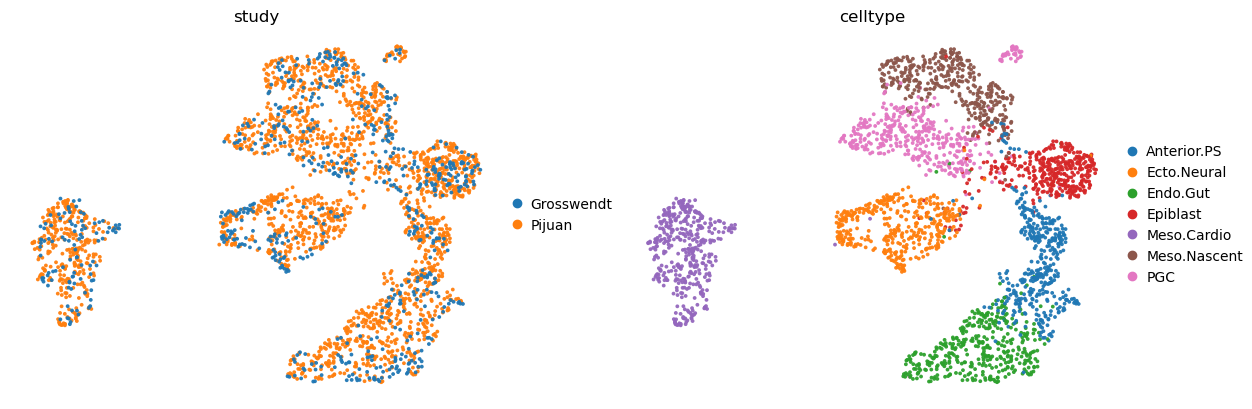

In [19]:
sc.tl.umap(adata_hvg)
sc.pl.umap(adata_hvg, color=['study', 'celltype'], size=30, alpha=.95,frameon=False)

The integration by BBKNN in this example looks pretty good! Note that in both this approach and the naive integration, the user would still need to perform some post-integration processing in order to label the query cells. This could easily be done by clustering and then assigning query cells based on the most frequent label of reference cells sharing the same cluster as query cells. Try to think of other approaches to this task.

### Method 3: ML Classification

In the third approach, we will directly annotate query cells by classifying them using a model trained on reference data. Our [PySingleCellNet (pySCN) package](https://pysinglecellnet.readthedocs.io/) was designed for this task ([Tan and Cahan 2019](https://pubmed.ncbi.nlm.nih.gov/31377170/)). SingleCellNet trains a random forest classifier on gene expression features derived from the reference data, and then applies it to classify query cells. It also includes tools to assess classification performance and to categorize predictions by confidence.

In [ ]:
adRef2 = sc.read_h5ad("data/ad_Pijuan_demo.h5ad")
adQuery = sc.read_h5ad("data/ad_Grosswendt_demo.h5ad")

In [20]:
cn.ut.limit_anndata_to_common_genes([adRef2, adQuery])

In [ ]:
n_cells = 100
groupby = 'celltype'
# Stratify the train/validation split by developmental stage so both sets have balanced stage representation
strata_col = 'stage'

tids, vids = cn.ut.split_adata_indices(adRef2, n_cells, groupby=groupby, cellid=None, strata_col=strata_col)

In [22]:
adTrain = adRef2[tids].copy()
adHO = adRef2[vids].copy()

In [23]:
sc.pp.highly_variable_genes(adTrain, n_top_genes=3000, flavor='seurat_v3')
sc.pp.normalize_total(adTrain)
sc.pp.log1p(adTrain)

In [ ]:
n_rand = n_cells
n_top_genes = 30
n_top_gene_pairs = 40
n_comps = 30
n_trees = 1000
obs_pred = "SCN_class_argmax"

clf = cn.tl.train_classifier(adTrain, groupby, n_rand=n_rand, n_top_genes=n_top_genes, n_top_gene_pairs=n_top_gene_pairs, n_comps=n_comps)

In [25]:
cn.tl.classify_anndata(adHO, clf)

In [ ]:
adHO

In [27]:
type(adHO.obsm)

anndata._core.aligned_mapping.AxisArrays

In [28]:
adHO.obsm

AxisArrays with keys: SCN_score

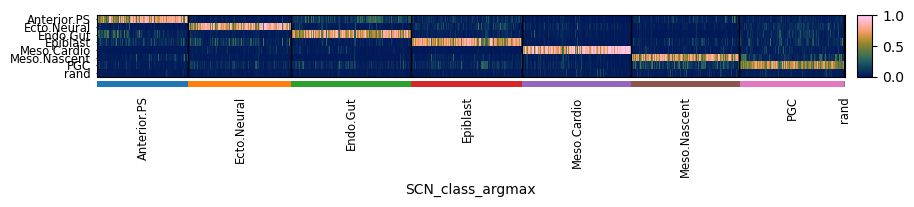

In [29]:
cn.pl.heatmap_scores(adHO, groupby = 'SCN_class_argmax')

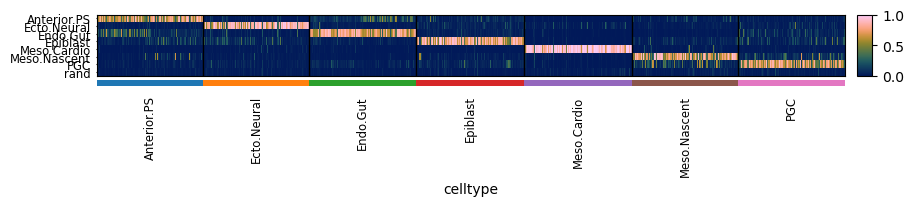

In [33]:
cn.pl.heatmap_scores(adHO, groupby = 'celltype')

In [35]:
c_report = cn.tl.create_classifier_report(adHO, ground_truth=groupby, prediction=obs_pred)

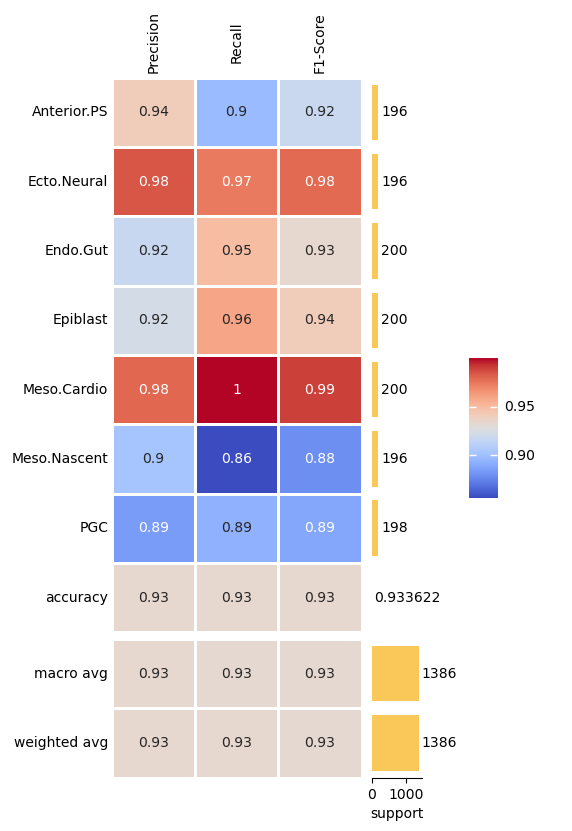

In [36]:
cn.pl.heatmap_classifier_report(c_report)

In [37]:
cn.tl.classify_anndata(adQuery, clf)

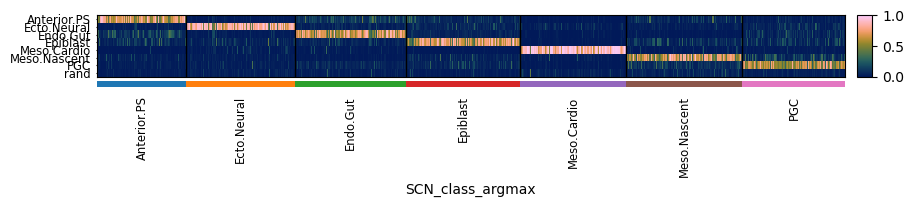

In [38]:
cn.pl.heatmap_scores(adQuery, groupby = 'SCN_class_argmax')

In [39]:
adQuery.obs['SCN_class_argmax'].value_counts()

SCN_class_argmax
Meso.Nascent    109
Epiblast        107
Endo.Gut        104
Ecto.Neural     102
Meso.Cardio      99
PGC              96
Anterior.PS      83
rand              0
Name: count, dtype: int64

In [40]:
c_report_2 = cn.tl.create_classifier_report(adQuery, ground_truth=groupby, prediction=obs_pred)

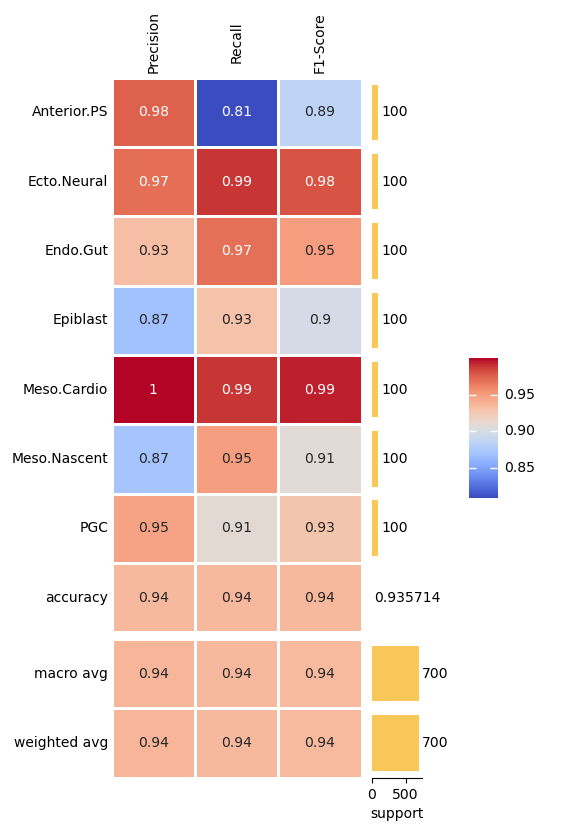

In [41]:
cn.pl.heatmap_classifier_report(c_report_2)

In [42]:
tThrs_val_05_HO = cn.tl.comp_ct_thresh(adHO, 0.05)

In [43]:
tThrs_val_05_HO

,0
Anterior.PS,0.41170
Ecto.Neural,0.39195
Endo.Gut,0.44590
Epiblast,0.36580
Meso.Cardio,0.54685
Meso.Nascent,0.42025
PGC,0.36690


In [44]:
rela_graph = cn.tl.paga_connectivities_to_igraph(adTrain, threshold = 0.3, n_comps = n_comps, group_key = groupby)

In [45]:
cn.tl.categorize_classification(adQuery, tThrs_val_05_HO, rela_graph)

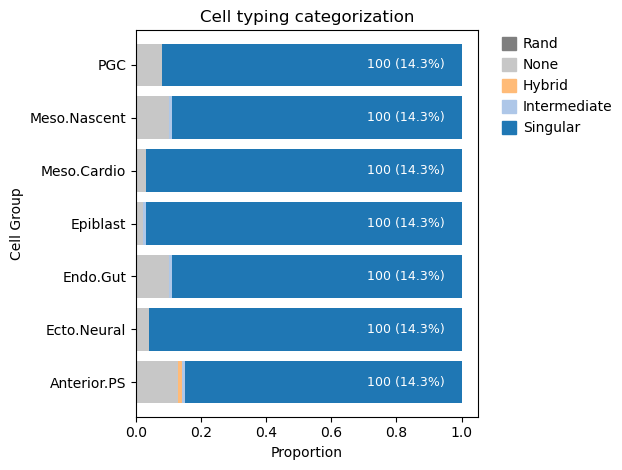

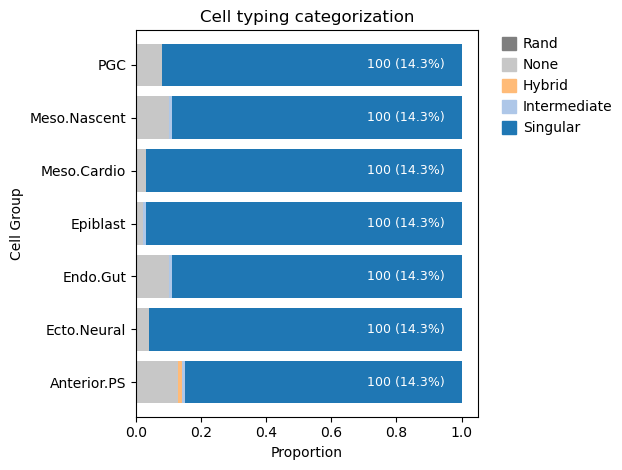

In [46]:
cn.pl.stackedbar_categories(adQuery, class_col_name='celltype', show_pct_total=True)

In [47]:
adQuery

AnnData object with n_obs × n_vars = 700 × 21133
    obs: 'embryo', 'stage', 'celltype', 'SCN_class_argmax', 'SCN_class_emp', 'SCN_class_type', 'SCN_class_cat'
    var: 'name'
    uns: 'SCN_class_argmax_colors'
    obsm: 'SCN_score'

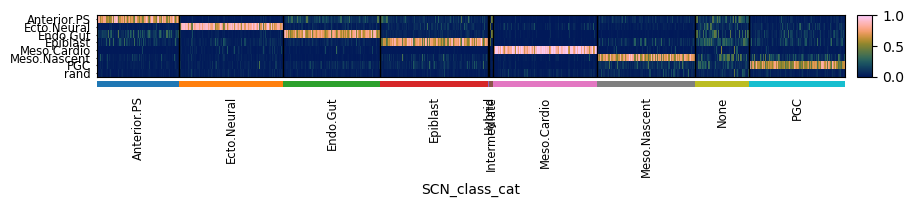

In [48]:
cn.pl.heatmap_scores(adQuery, groupby = 'SCN_class_cat')

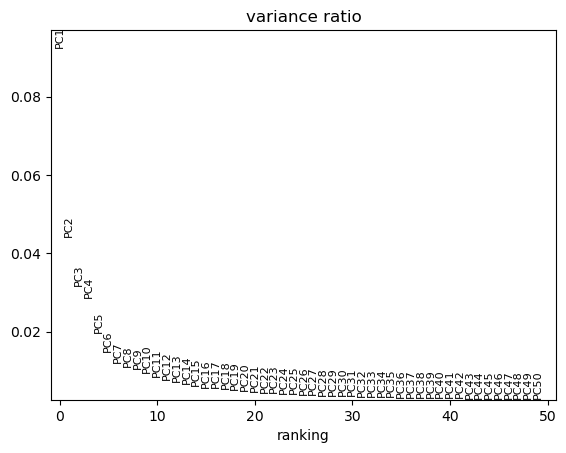

In [49]:
adtest2 = adQuery.copy()
adtest2.layers['counts'] = adtest2.X.copy()
sc.pp.normalize_total(adtest2)
sc.pp.log1p(adtest2)
sc.pp.highly_variable_genes(adtest2, n_top_genes=3000, flavor='seurat_v3', layer='counts')
sc.tl.pca(adtest2, mask_var='highly_variable')
sc.pl.pca_variance_ratio(adtest2, n_pcs=50)

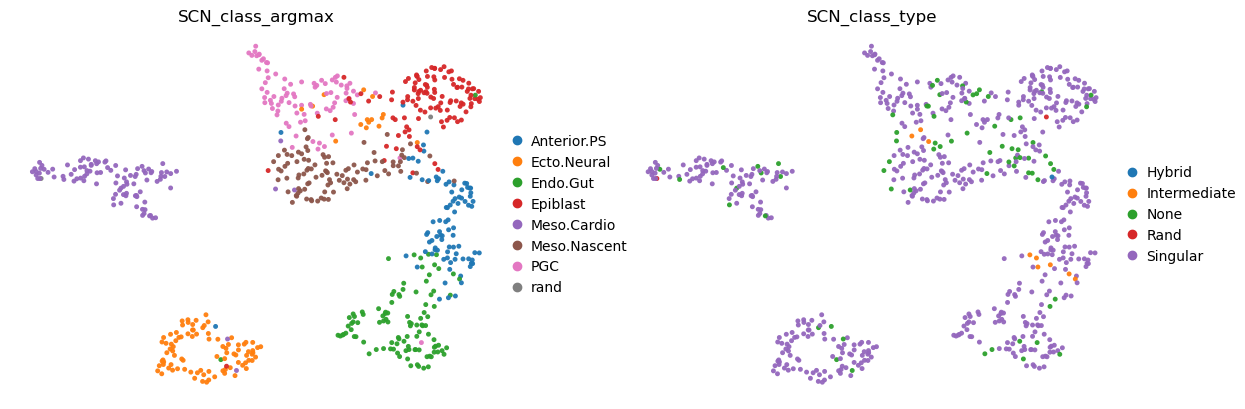

In [48]:
def_npcs = 30
def_nneigh = 10
sc.pp.neighbors(adtest2, n_neighbors = def_nneigh,  n_pcs = def_npcs)
sc.tl.umap(adtest2)
sc.pl.umap(adtest2, color=['SCN_class_argmax', 'SCN_class_type'], size=50, alpha=.95,frameon=False)